In [1]:
#using Revise
using DrWatson
@quickactivate "ABoxWorld"
include(srcdir("ABoxWorld.jl"));

┌ Info: ABoxWorld project environment is loaded and active
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\src\ABoxWorld.jl:10


In [2]:
using LinearAlgebra
using TensorOperations
using CairoMakie
CairoMakie.activate!()

#using GLMakie
#GLMakie.activate!()

In [3]:

convert_matrixbox_to_nsjoint = wirings.convert_matrixbox_to_nsjoint
convert_nsjoint_to_matrixbox = wirings.convert_nsjoint_to_matrixbox


# Boxes as 2x2x2x2 tensors

MaxMixedBox = nsboxes.reconstructFullJoint(UniformRandomBox((2, 2, 2, 2)))
PR(μ, ν, σ) = nsboxes.reconstructFullJoint(PRBoxesCHSH(;μ=μ, ν=ν, σ=σ))
CanonicalPR = PR(0, 0, 0)
PL(α, γ, β, λ) = nsboxes.reconstructFullJoint(LocalDeterministicBoxesCHSH(;α=α, γ=γ, β=β, λ=λ))
SR = (PL(0,0,0,0) .+ PL(0,1,0,1)) ./ 2
#SR = matrix_to_tensor(non_local_boxes.utils.SR)
#PRprime = matrix_to_tensor(non_local_boxes.utils.PRprime)
#P0 = matrix_to_tensor(non_local_boxes.utils.P_0)
#P1 = matrix_to_tensor(non_local_boxes.utils.P_1)


CHSH_score = games.canonical_CHSH_score
#CHSHprime_score = games.CHSH_score_generator(-1,1,1,1; batched=false)
CHSHprime_score = games.CHSH_score_generator(1,-1,1,1; batched=false)


BoxProduct = wirings.tensorized_boxproduct
reduc_BoxProduct = wirings.reduc_tensorized_boxproduct
BoxProduct_matrices(w::Matrix{<:Real}, matrixbox1::Matrix{Float64}, matrixbox2::Matrix{Float64}) = convert_nsjoint_to_matrixbox(reduc_BoxProduct(w, matrixbox1, matrixbox2))


IC_Bound = Original_IC_Bound()
IC_Bound_LHS(P::Array{Float64, 4}) = conditions.evaluate(IC_Bound, P)
IC_Bound_LHS(W::Matrix{<:Real}, P_mat::Matrix{Float64}, Q_mat::Matrix{Float64}) = games.Original_IC_Bound_score(W, P_mat, Q_mat)
IC_Bound_LHS(W::Vector{<:Real}, P_mat::Matrix{Float64}, Q_mat::Matrix{Float64}) = games.Original_IC_Bound_score(W, P_mat, Q_mat)

IC_MutInfo = games.MutInfo_IC_vanDam_score



MutInfo_IC_vanDam_score (generic function with 5 methods)

In [4]:

function Compute_Coeff(P1::Array{Float64,4}, P2::Array{Float64,4}, P3::Array{Float64,4}, alt_G_score_val::Real, CHSH_score_val::Real, alt_Game_score::Function) # P1, P2, P3 are 2x2x2x2 tensors
    A = [alt_Game_score(P1) alt_Game_score(P2) alt_Game_score(P3);
           CHSH_score(P1)     CHSH_score(P2)     CHSH_score(P3);
                1                    1                1           ]
    b = [alt_G_score_val, CHSH_score_val, 1]
    return A \ b # Equiv. to np.linalg.solve(A, b)
end


function is_in_NPA_TLM(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    #return conditions.check(NPA_TLM_Criterion(), Box)

    E_xy = ProbBellCorrelator(Box)
    coeff00 = asin(E_xy[1,1])
    coeff01 = asin(E_xy[1,2])
    coeff10 = asin(E_xy[2,1])
    coeff11 = asin(E_xy[2,2])
    return coeff00 + coeff01 + coeff10 - coeff11 <= pi
end



function is_in_NPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.is_in_NPA(Box; level=level, verbose=false)    
end



function is_asymp_in_pyNPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.is_asymp_in_pyNPA(Box; level=level, verbose=false)
end


function is_in_pyNPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    Box = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.is_in_pyNPA(Box; level=level, verbose=false)
end

function min_distance_to_pyNPA(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    p_obs = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.min_distance_to_pyNPA(p_obs; level=level, verbose=false)
end

    
function nearest_pyNPA_point(alt_G_score_val::Real,CHSH_score_val::Real, Box1::Array{Float64,4}, Box2::Array{Float64,4}, Box3::Array{Float64,4}, alt_Game_score::Function, level::Int)
    α, β, γ = Compute_Coeff(Box1, Box2, Box3, alt_G_score_val, CHSH_score_val, alt_Game_score)
    p_obs = α*Box1 + β*Box2 + γ*Box3
    # Box is a 2x2x2x2 tensor
    return sdp_conditions.nearest_pyNPA_point(p_obs; level=level, verbose=false)
end


nearest_pyNPA_point (generic function with 1 method)

In [5]:

function greedy_sufficient_box_in_orbits(P::Array{Float64, 4}, W_vec::Vector{Float64}, max_wiring_order::Int, scoring_functional::Function, threshold::Real)    
    """ If there is a notion of a "sufficiently good" box, then we can stop early; Not always neccesary to compute orbits up to max_wiring_order. """
    
    W = reshape(W_vec,:,1)  #Bevause of the nature of the tensorized boxproduct, W must be in batched form
    
    if scoring_functional(P) > threshold #0-th order orbit is already good enough
        return max_value, P, 0 #max_value, best_box, order
    else
        # Look at all possible ways to multiply P with itself via W:
        Qs = (deepcopy(P), deepcopy(P), deepcopy(P)) #Qright, Qcenter, Qleft
    
        for c_order in 1:max_wiring_order
            Qs = (reduc_BoxProduct(W, Qs[1], P), reduc_BoxProduct(W, Qs[2], Qs[2]), reduc_BoxProduct(W, P, Qs[3]))  #Qright, Qcenter, Qleft
        
            max_val, max_idx = findmax([scoring_functional(Qs[1]), scoring_functional(Qs[2]), scoring_functional(Qs[3])])
            
            if max_val > threshold
                return max_val, Qs[max_idx], c_order
            end
        end
    end
end


function greedy_best_box_in_orbit(P::Array{Float64, 4}, W_vec::Vector{Float64}, wiring_order::Int, scoring_functional::Function)
    """Greedy way to obtain best scoring box in given orbit(order), without need to compute all boxes in all orbits"""
    
    W = reshape(W_vec,:,1)  #Bevause of the nature of the tensorized boxproduct, W must be in batched form

    # Look at all possible ways to multiply P with itself via W:
    Qs = (deepcopy(P), deepcopy(P), deepcopy(P)) #Qright, Qcenter, Qleft

    max_scores = []
    c_max_score, c_best_box = scoring_functional(P), P

    for c_order in 1:wiring_order
        Qs = (reduc_BoxProduct(W, Qs[1], P), reduc_BoxProduct(W, Qs[2], Qs[2]), reduc_BoxProduct(W, P, Qs[3]))  #Qright, Qcenter, Qleft
    
        c_max_score, max_idx = findmax([scoring_functional(Qs[1]), scoring_functional(Qs[2]), scoring_functional(Qs[3])])
        c_best_box = Qs[max_idx]
        push!(max_scores, c_max_score)
    end
    return max_scores, c_max_score, c_best_box
end

function compute_full_orbits(P::Array{Float64, 4}, W::Vector{Float64}, max_wiring_order::Int)
    orbits = [[P]]  # each all_orbits[k] is a vector, which is the orbit of depth k
    for k in 1:max_wiring_order
        push!(orbits, [])
        for l in 1:k
            for Q1 in orbits[l]
                for Q2 in orbits[k-l]
                    push!(orbits[k], reduc_BoxProduct(W, Q1, Q2) )
                end
            end
        end
    end
    return orbits
end

compute_full_orbits (generic function with 1 method)

##### Distances:

Idea = KL(P || Q) measures how much reduncancy description Q has w.r.t. true description by P. So if P original box and Q wired box, then ... However, JS_divergence even in both direction = how good we can distinguish two distributions in a mixture.

In [6]:
using Statistics: mean
using Distances

function prepare_KL_Div_BoxDistance(initial_P::Array{Float64, 4})
    initial_P = max.(initial_P, 1e-10) #Make sure we don't have negative probabilities
    initial_P = min.(initial_P, 1.0 - 1e-10) #Make sure we don't have probabilities > 1

    function KL_Div_BoxDistance(target_P::Array{Float64, 4})
        #Deal pragmatically with the log-domain problem by clamping:
        target_P = max.(target_P, 1e-10) #Make sure we don't have negative probabilities
        target_P = min.(target_P, 1.0 - 1e-10) #Make sure we don't have probabilities > 1
        return mean(Distances.kl_divergence(target_P[1:end,1:end, i, j], initial_P[1:end,1:end, i, j]) for (i,j) in Iterators.product(1:2, 1:2))
    end

    return KL_Div_BoxDistance
end


function prepare_JS_Div_BoxDistance(initial_P::Array{Float64, 4})
    initial_P = max.(initial_P, 1e-10) #Make sure we don't have negative probabilities
    initial_P = min.(initial_P, 1.0 - 1e-10) #Make sure we don't have probabilities > 1

    function JS_Div_BoxDistance(target_P::Array{Float64, 4})
        #Deal pragmatically with the log-domain problem by clamping:
        target_P = max.(target_P, 1e-10) #Make sure we don't have negative probabilities
        target_P = min.(target_P, 1.0 - 1e-10) #Make sure we don't have probabilities > 1
        return mean(Distances.js_divergence(target_P[1:end,1:end, i, j], initial_P[1:end,1:end, i, j]) for (i,j) in Iterators.product(1:2, 1:2))
    end

    return JS_Div_BoxDistance
end

function prepare_NPA_BoxDistance(initial_P::Array{Float64, 4}; membership_level::Int=3, distance_level::Int=2)
    #initial_distance = sdp_conditions.min_distance_to_pyNPA(initial_P; level=distance_level)
    function NPA_BoxDistance(target_P::Array{Float64, 4})
        if !sdp_conditions.is_in_NPA(target_P; level=membership_level)
            return sdp_conditions.min_distance_to_pyNPA(target_P; level=distance_level) # - initial_distance
        else
            return 0.0
        end
    end
    return NPA_BoxDistance
end


prepare_NPA_BoxDistance (generic function with 1 method)

In [7]:

 #Extremal wire types & parameters (binary):
 extremal_wiring_params = Dict(:D => [:α,], 
 :O => [:α, :β, :γ], 
 :X => [:α, :β, :γ],
 :A => [:α, :β, :γ, :δ, :ε],
 :S => [:α, :β, :γ, :δ, :ε],
 )

#Precompute the extremal wirings in the Dict format of extremal_wiring_params
extremal_wires_dict = Dict()
for (wiretype_A, wiretype_B) in Iterators.product(keys(extremal_wiring_params), keys(extremal_wiring_params))
    for c_wire_params_B in Iterators.product((0:1 for _ in 1:length(extremal_wiring_params[wiretype_B]))...)
        for c_wire_params_A in Iterators.product((0:1 for _ in 1:length(extremal_wiring_params[wiretype_A]))...)
            extremal_wires_dict[(wiretype_A, c_wire_params_A, wiretype_B, c_wire_params_B)] = extremal_wires(wiretype_A, Dict(zip(extremal_wiring_params[wiretype_A], c_wire_params_A)), wiretype_B, Dict(zip(extremal_wiring_params[wiretype_B], c_wire_params_B)))
        end
    end
end


function compute_wire_distances(config::Dict; verbose::Bool=false)
    """
    Expects in config: 
        metric::Symbol
        Box1::Pair{String, Array{Float64,4}}
        Box2::Pair{String, Array{Float64,4}}
        Box3::Pair{String, Array{Float64,4}}
        max_wiring_order::Int
        primary_score::Function = CHSH_score
        secondary_score::Function
        precision::Float64
        dist_resolution::Float64
    """
    results = copy(config)
        
    P1, P2, P3 = config["Box1"].second, config["Box2"].second, config["Box3"].second
    alt_Game_score = config["secondary_score"]
    precision = config["precision"]
    
    # Draw the initial background triangle:
    x1, y1 = alt_Game_score(P1), CHSH_score(P1) #Stays CHSH because it's the coordinate system of the plot, also in IC
    x2, y2 = alt_Game_score(P2), CHSH_score(P2)
    x3, y3 = alt_Game_score(P3), CHSH_score(P3)
    ns_extremes = [(x1, y1), (x2, y2), (x3, y3)]
    results["ns_extremes"] = ns_extremes

    # Check if our coordinate system is good, i.e. if projected points aren't aligned (= allow 2D viz.):
    ( (x1 - x3)*(y2-y3)==(x2-x3)*(y1-y3) ) && error("We can't make a 2D plot from a 0D or 1D space of points.")
    
    # Draw Q-set distances
    dist_resolution = config["dist_resolution"]
    wire_distances = Dict()
    ns_alt_G_scores = min(x2,x3):dist_resolution:max(x2, x3)
    ns_CHSH_scores = 2:dist_resolution:4

    for c_extremal_wiring_types in Iterators.product(keys(extremal_wiring_params), keys(extremal_wiring_params))
        wire_distances[c_extremal_wiring_types] = Matrix{Union{Float64, Missing}}(undef, length(ns_alt_G_scores), length(ns_CHSH_scores))
    end

    println("Computing wire distances...")
    for (x_coord, c_alt_G_score_val) in collect(enumerate(ns_alt_G_scores))
        for (y_coord, c_CHSH_score_val) in enumerate(ns_CHSH_scores)
            
            if c_CHSH_score_val - precision >= maximum(ns_CHSH_scores) - c_alt_G_score_val  #Not on the canvas of our viz anymore?
                for c_extremal_wiring_types in Iterators.product(keys(extremal_wiring_params), keys(extremal_wiring_params))
                    wire_distances[c_extremal_wiring_types][x_coord, y_coord] = missing
                end
                break #stay in upper ns-triangle on canvas
            end

            @show (c_alt_G_score_val, c_CHSH_score_val)

            initial_α, initial_β, initial_γ = Compute_Coeff(P1, P2, P3, c_alt_G_score_val, c_CHSH_score_val, alt_Game_score)
            initial_box = initial_α*P1 + initial_β*P2 + initial_γ*P3
            
            if config["metric"] == :KL_Div
                dist_metric = prepare_KL_Div_BoxDistance(initial_box)
            elseif config["metric"] == :JS_Div
                dist_metric = prepare_JS_Div_BoxDistance(initial_box)
            elseif config["metric"] == :NPA_Dist
                dist_metric = prepare_NPA_BoxDistance(initial_box)
            else
                error("Unknown metric")
            end

            for c_extremal_wiring_types in Iterators.product(keys(extremal_wiring_params), keys(extremal_wiring_params))
                typepair_distance_cache = []
                for c_extremal_wiring_params_pair in Iterators.product(Iterators.product((0:1 for _ in 1:length(extremal_wiring_params[c_extremal_wiring_types[1]]))...), Iterators.product((0:1 for _ in 1:length(extremal_wiring_params[c_extremal_wiring_types[2]]))...))
                    
                    c_extremal_wires = extremal_wires_dict[(c_extremal_wiring_types[1], c_extremal_wiring_params_pair[1], c_extremal_wiring_types[2], c_extremal_wiring_params_pair[2])]

                    c_max_dist_vals, c_max_dist, c_max_wired_box = greedy_best_box_in_orbit(initial_box, c_extremal_wires, config["max_wiring_order"], dist_metric)                
                    #c_max_wired_point = (alt_Game_score(c_max_wired_box ), CHSH_score(c_max_wired_box ))
                    push!(typepair_distance_cache, c_max_dist)
                end
                wire_distances[c_extremal_wiring_types][x_coord, y_coord] = maximum(typepair_distance_cache)
            end
        end
    end
    results["wire_distances"] = wire_distances
    
    """
    # Compute the Quantum area:
    c_alt_G_score_val=min(x2,x3) #Initialize at x-axis origin
    c_CHSH_score_val=4 #Safely initialize at the maximum local value of CHSH
    Quantum_alt_G_scores = Float64[]
    Quantum_CHSH_scores = Float64[]
    while c_alt_G_score_val <= max(x2, x3)
        #Check NPA-Q membership with and without security check
        if is_in_NPA(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score, member_npa_level)
        #if is_in_NPA(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score, member_npa_level) && is_asymp_in_pyNPA(c_alt_G_score_val, c_CHSH_score_val, P1, P2, P3, alt_Game_score, member_npa_level)
            push!(Quantum_alt_G_scores, c_alt_G_score_val)
            push!(Quantum_CHSH_scores, c_CHSH_score_val)
            c_alt_G_score_val+=precision # Go to the next point along x-axis / vertical line 
            
        else #Else we go down along y-axis towards the Q set. 
            if c_CHSH_score_val - precision > y2  #Still on the canvas of our viz.
                c_CHSH_score_val -= precision
            else
                c_CHSH_score_val=y2 #Take the canvas lower-boundary as the quantum boundary (even if it's not in the Q set) 
                c_alt_G_score_val+=precision # Go to the next point along x-axis / vertical line 
            end
        end
    end
    """
    return results
end

compute_wire_distances (generic function with 1 method)

In [13]:
c_config = Dict(
    "metric"=> :JS_Div, #:KL_Div, #:JS_Div,
    "Box1"=> ("PR"=>CanonicalPR),
    "Box2"=> ("I"=>MaxMixedBox),
    "Box3"=> ("PL(0,0,0,0)"=> PL(0,0,0,0)),
    "max_wiring_order" => 2,
    "secondary_score"=>CHSHprime_score,
    "precision"=>1.4e-2,
    "dist_resolution"=>0.1,#0.1,#0.02,
    )

#output = compute_wire_distances(c_config; verbose=true)

data_output, data_filename = produce_or_load(compute_wire_distances, 
                c_config,
                mkpath(datadir("wire_distances"));
                prefix="WireDistances",
                filename=string(c_config["metric"])*"_"*c_config["Box1"].first*"_"*c_config["Box2"].first*"_"*c_config["Box3"].first*"_MaxOrder_"*string(c_config["max_wiring_order"]),
                verbose=true,
                )


┌ Info: File s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\data\wire_distances\WireDistances_JS_Div_PR_I_PL(0,0,0,0)_MaxOrder_2.jld2 does not exist. Producing it now...
└ @ DrWatson C:\Users\trothe\.julia\packages\DrWatson\rXaRB\src\saving_files.jl:105


Computing wire distances...
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 2.0)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 2.1)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 2.2)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 2.3)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 2.4)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 2.5)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 2.6)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 2.7)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 2.8)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 2.9)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 3.0)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 3.1)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 3.2)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 3.3)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 3.4)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 3.5)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 3.6)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 3.7)
(c_alt_G_score_val, c_CHSH_score_val) = (0.0, 3.8)
(c_

┌ Warning: The Git repository ('s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld') is dirty! Appending -dirty to the commit ID.
└ @ DrWatson C:\Users\trothe\.julia\packages\DrWatson\rXaRB\src\saving_tools.jl:64
┌ Info: File s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\data\wire_distances\WireDistances_JS_Div_PR_I_PL(0,0,0,0)_MaxOrder_2.jld2 saved.
└ @ DrWatson C:\Users\trothe\.julia\packages\DrWatson\rXaRB\src\saving_files.jl:114


(Dict{String, Any}("secondary_score" => Main.games.var"#abs_CHSH_score#4"{Int64, Int64, Int64, Int64}(1, -1, 1, 1), "max_wiring_order" => 2, "precision" => 0.014, "gitcommit" => "fe3e514465bcbcceaeb760093fb2db108105cb48-dirty", "Box3" => ("PL(0,0,0,0)" => [1.0 0.0; 0.0 0.0;;; 1.0 0.0; 0.0 0.0;;;; 1.0 0.0; 0.0 0.0;;; 1.0 0.0; 0.0 0.0]), "wire_distances" => Dict{Any, Any}((:D, :D) => Union{Missing, Float64}[0.4452730305448658 0.4494654854580497 … 0.5604163374841262 0.5738007711191413; 0.45356458535220456 0.4578383270489405 … 0.577287207352864 missing; … ; 0.667215527165072 0.678455688221137 … missing missing; 0.6931471781573602 missing … missing missing], (:X, :S) => Union{Missing, Float64}[0.05575802783997999 0.0608452346121344 … 0.44167390121022293 0.5198603820240255; 0.05939623659660642 0.0657906781737549 … 0.45897981364241786 missing; … ; 0.6209969631285774 0.6595907252104134 … missing missing; 0.6931471781573602 missing … missing missing], (:X, :X) => Union{Missing, Float64}[0.05400

In [15]:
data_output["wire_distances"][(:A, :X)]

21×21 Matrix{Union{Missing, Float64}}:
 0.187514  0.191226  0.195115  0.19919   …  0.349332  0.376621  0.414529
 0.191046  0.19468   0.198484  0.202468     0.360348  0.394625   missing
 0.195251  0.19885   0.202619  0.206568     0.383395   missing   missing
 0.199877  0.203464  0.207225  0.211169      missing   missing   missing
 0.205762  0.210594  0.215678  0.22103       missing   missing   missing
 0.224094  0.228918  0.234011  0.239389  …   missing   missing   missing
 0.244199  0.249036  0.254162  0.259594      missing   missing   missing
 0.266046  0.270918  0.276102  0.281619      missing   missing   missing
 0.289604  0.294535  0.299805  0.305444      missing   missing   missing
 0.314839  0.319855  0.325246  0.331047      missing   missing   missing
 ⋮                                       ⋱                      ⋮
 0.400185  0.405663  0.411687  0.418337      missing   missing   missing
 0.431674  0.437399  0.443767  0.450893      missing   missing   missing
 0.464579  0.470619

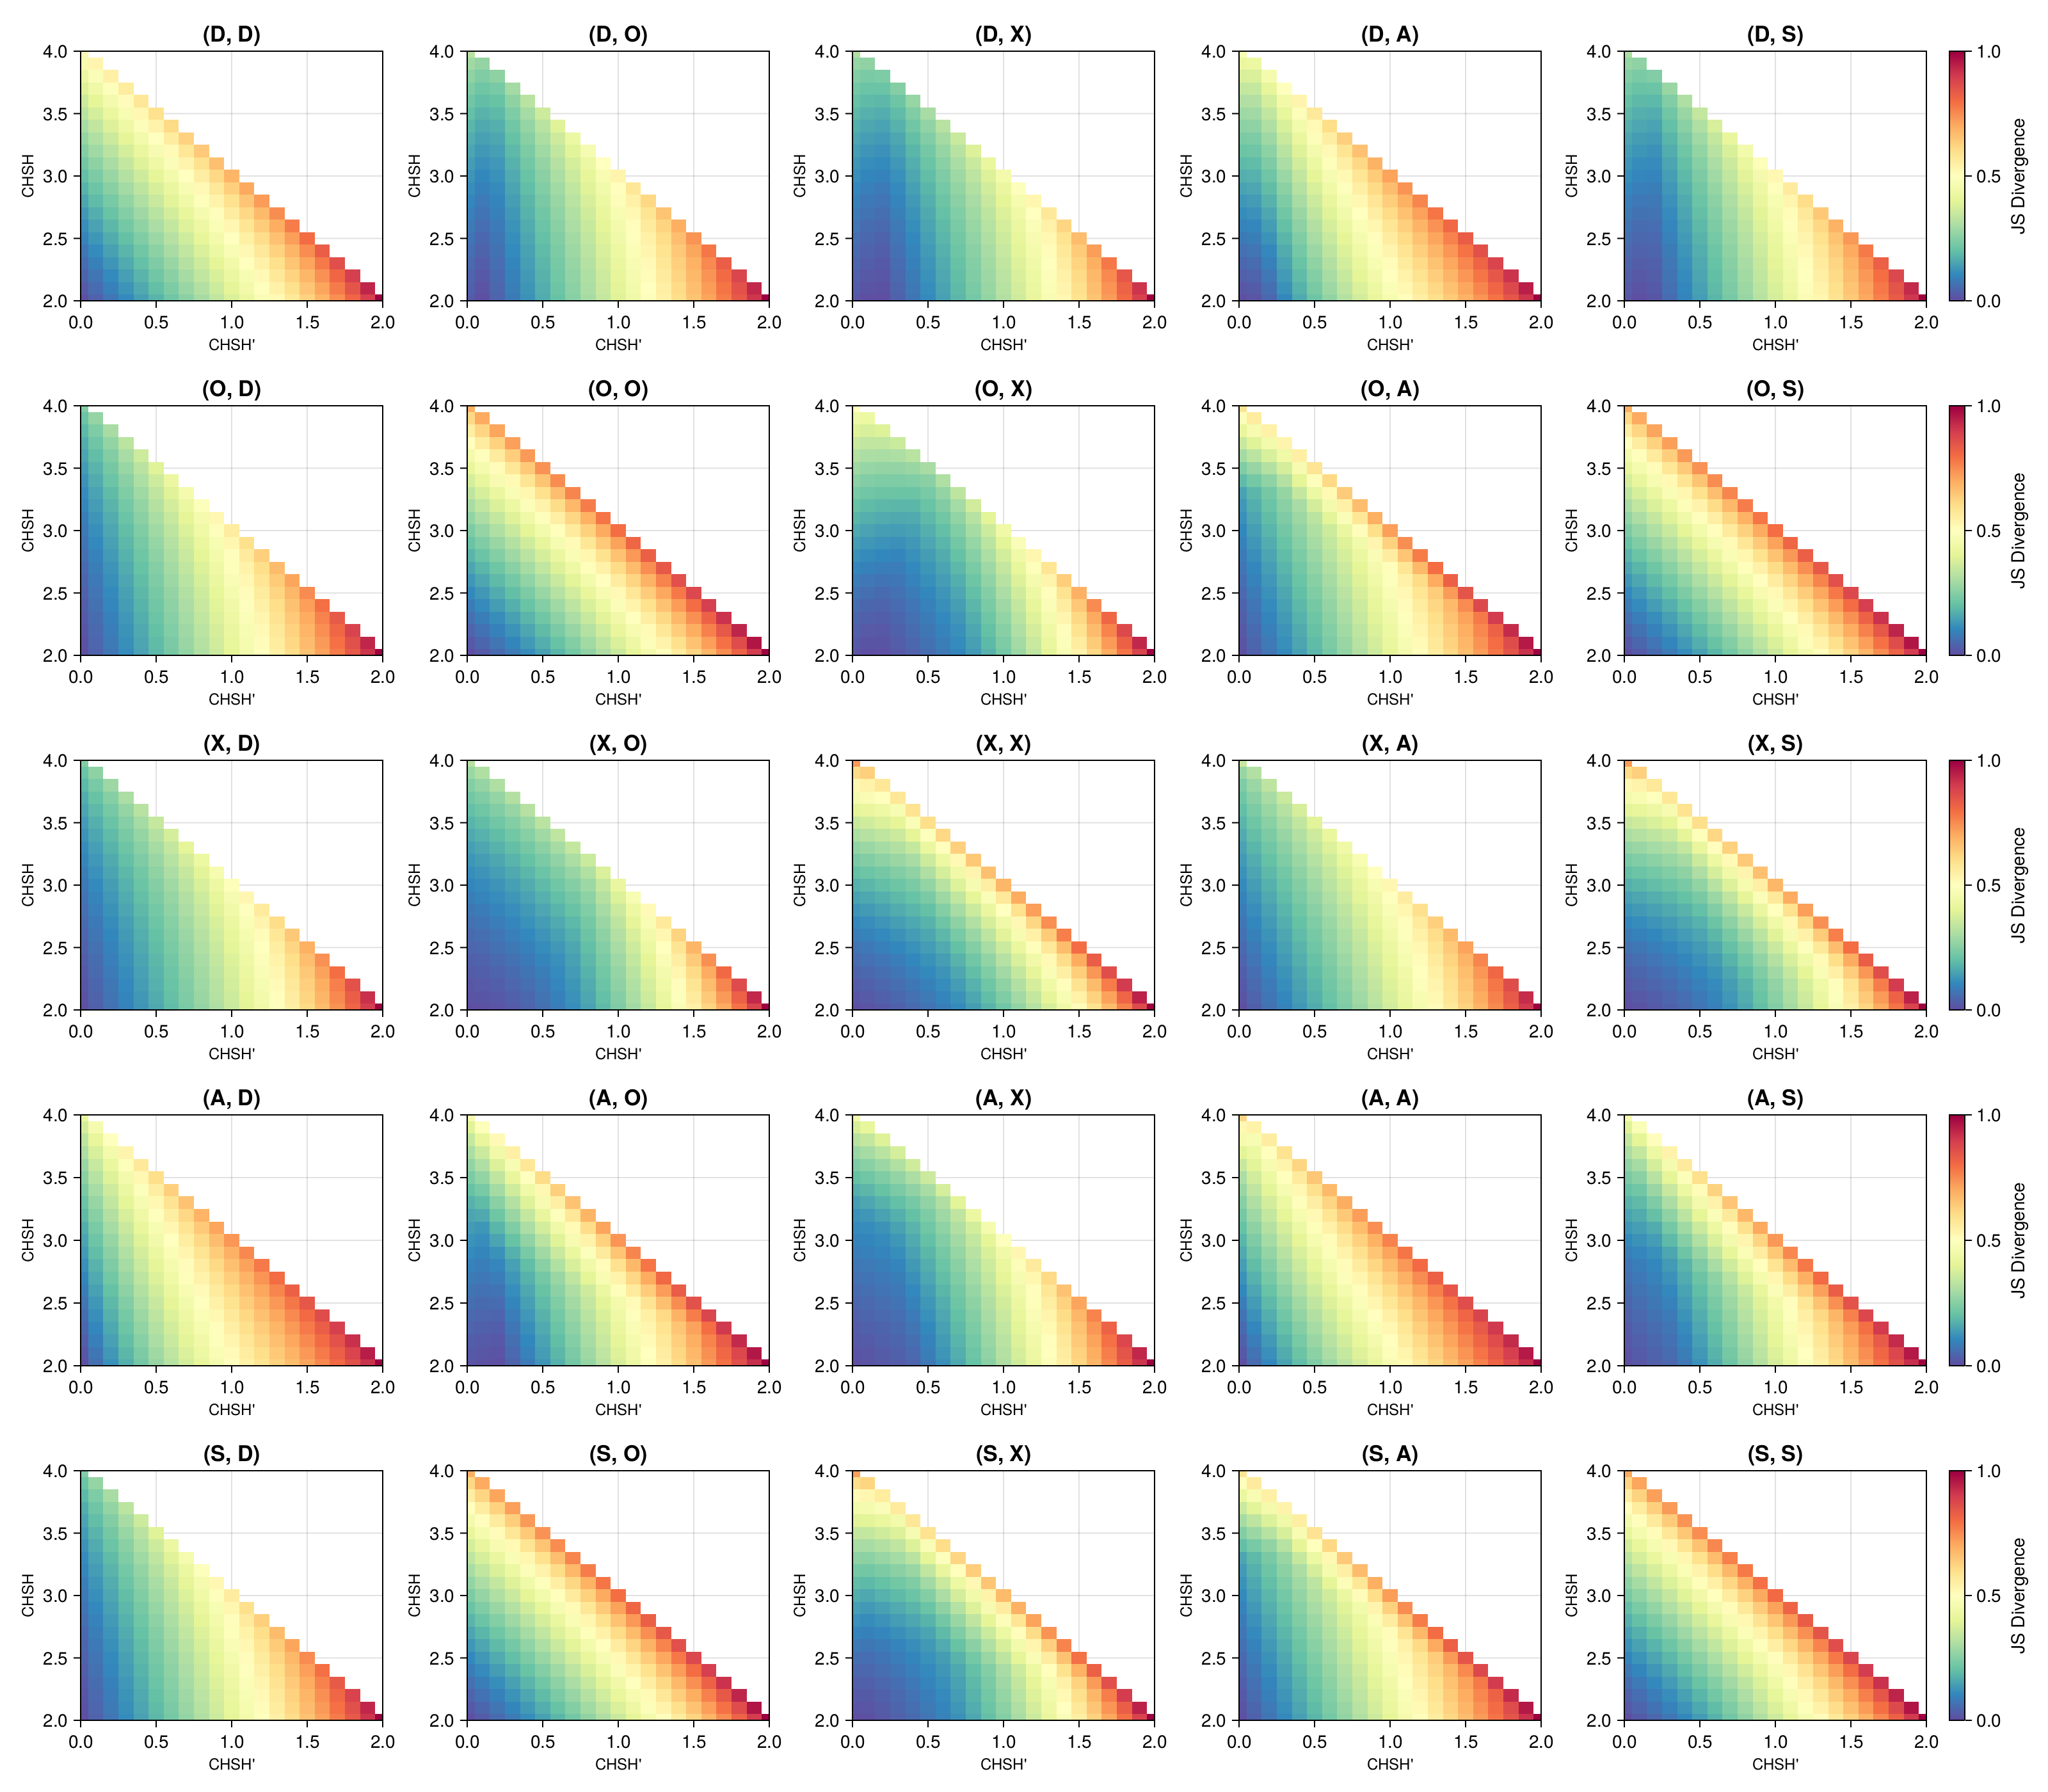

In [22]:

#using GLMakie
#GLMakie.activate!()
using CairoMakie
CairoMakie.activate!()
typelabel_order = Dict(:D => 1, :O => 2, :X => 3, :A => 4, :S => 5)

function plot_wire_distances(data::Dict; markersize::Real=4, big::Bool=true)
    
    # Initialize figure and colors:
    Pawlowski2009_color = :deepskyblue3
    wired_IC_color = :orangered
    NS_color = :black
    Quantum_color = "#e82051"

    fig = Figure(; size=(1600,1400))

    ns_x_vals = collect(min(data["ns_extremes"][2][1], data["ns_extremes"][3][1]):data["dist_resolution"]:max(data["ns_extremes"][2][1], data["ns_extremes"][3][1]))
    ns_y_vals = collect(2:data["dist_resolution"]:4)
    for (wire_type_A_i, wire_type_A) in enumerate(keys(extremal_wiring_params)) 
        for (wire_type_B_i, wire_type_B) in enumerate(keys(extremal_wiring_params))
            wire_type_A_pos = typelabel_order[wire_type_A]
            wire_type_B_pos = typelabel_order[wire_type_B]
            ax = Axis(fig[wire_type_A_pos, wire_type_B_pos]; xlabel = "CHSH'", ylabel = "CHSH", xlabelsize=(big ? 12 : 10), ylabelsize=(big ? 12 : 10),
                titlevisible=true, titlesize=17, title ="($wire_type_A, $wire_type_B)",
                )
            xlims!(ax, min(map(first, data["ns_extremes"])...), max(map(first, data["ns_extremes"])...))
            ylims!(ax, 2, 4)

            hm = heatmap!(ax, ns_x_vals, ns_y_vals, data["wire_distances"][(wire_type_A, wire_type_B)]; colormap = Reverse(:Spectral) ) # transparency = 0.5colorrange = (0, 1),
        end
    end

    if data["metric"] == :JS_Div
        colorbar_label =  "JS Divergence"
    elseif data["metric"] == :KL_Div
        colorbar_label =  "KL Divergence"
    else
        colorbar_label =  "Unknown metric"
    end

    n_fig_rows, n_fig_cols = size(fig.layout)
    for fig_row in 1:n_fig_rows
        Colorbar(fig[fig_row, n_fig_cols+1], limits = (0.0, 1.0), colormap =Reverse(:Spectral), label=colorbar_label)
    end
    
    """
    text!(ax, Box1.first, position=(x1+0.001, y1), space = :data, align = (:center, :baseline),font = :bold)
    text!(ax, Box2.first, position=(x2, y2-0.007), space = :data, align = (:center, :center),font = :bold)
    text!(ax, Box3.first, position=(x3, y3-0.007), space = :data, align = (:center, :center),font = :bold)

    #Draw the Boundary of the NS set:
    ns_boundary_line = lines!(ax, [x1, x2, x3, x1], [y1, y2, y3, y1]; color=NS_color, linewidth=3)


    quantum_boundary_line = lines!(ax, Quantum_alt_G_scores, Quantum_CHSH_scores; color=Quantum_color, linewidth=3)

   
    #Misc. plot settings:
    
    legend_visible = true
    legend_visible ? (axislegend(ax, [ns_boundary_line, quantum_boundary_line], 
                    ["NS boundary","Quantum boundary"];
                    position = :rt, labelsize = (big ? 10.5 : 9.5) )) : nothing
    
    """
    
    save(plotsdir("wire_distances")*"/"*"1"*".png", fig)

    fig # equiv. to plt.show()
end

plot_wire_distances(data_output)